In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2
import string
import visualkeras
from PIL import ImageFont

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)


# Images in the dataset

In [2]:
image_paths = []
for dirname, _, filenames in os.walk('captchas/letters'):
    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg'):
            image_paths.append(os.path.join(dirname, filename))
image_paths = np.array(image_paths)

print(image_paths.shape)

(1070,)


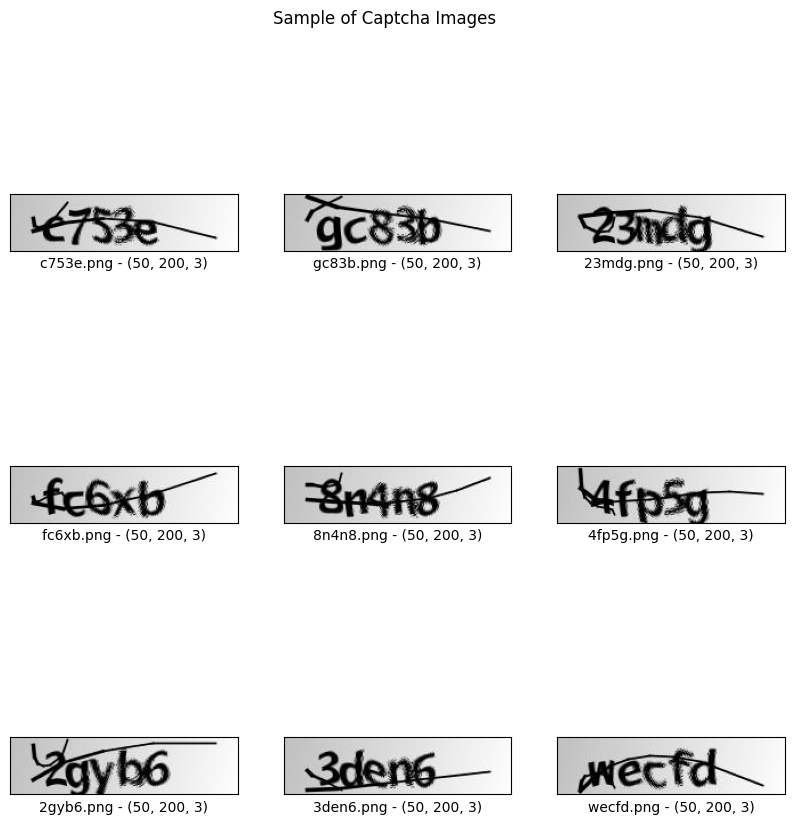

In [3]:
plt.figure(figsize=(10, 10))

num_samples = 9
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(image_paths)), size=num_samples, replace=False)

sample_images = image_paths[indices]

for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread(str(sample_images[i]))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(f"{sample_images[i].split('/')[-1]} - {img.shape}")
plt.suptitle('Sample of Captcha Images')
plt.show()

# Setting up dataset

In [4]:
NUM_OF_LETTERS = 5

characters = set()
captcha_length = []
dataset = []
for img_path in image_paths:
    label = img_path.split("/")[-1].split(".")[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))
    
characters = sorted(string.ascii_lowercase+string.ascii_uppercase+string.digits)    

dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)

print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(captcha_length))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  62
Maximum length of any captcha:  5
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of samples in the dataset:  1070


,img_path,label
0,captchas/letters/pm363.png,pm363
1,captchas/letters/n336e.png,n336e
2,captchas/letters/fw3b2.png,fw3b2
3,captchas/letters/56c34.png,56c34
4,captchas/letters/mc8w2.png,mc8w2


# Training and testing data

In [5]:
train, test = train_test_split(dataset, test_size=0.15, random_state=seed)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("Number of training samples: ", len(train))
print("Number of test samples: ", len(test))

Number of training samples:  909
Number of test samples:  161


In [6]:
def encode_label(label, max_len=5):
    encoded = np.zeros((max_len, len(characters)))
    for i in range(max_len):
        encoded[i, characters.index(label[i])] = 1
    return encoded

def decode_label(encoded):
    label = ""
    for i in range(encoded.shape[0]):
        label += characters[np.argmax(encoded[i])]
    return label

def gen_xy(df, img_height=50, img_width=200):
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width, 3), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        label = df["label"][i]
        img = np.reshape(img, (img.shape[0], img.shape[1], 3))
        images[i, :, :] = img
        labels[i] = encode_label(label)
    
    return images.astype('float32')/255, np.array(labels, dtype=object).astype('float32')


X_train, y_train = gen_xy(df=train, img_height=50, img_width=200)
X_test, y_test = gen_xy(df=test, img_height=50, img_width=200)

print("Number of training images: ", X_train.shape)
print("Number of training labels: ", y_train.shape)

print("Number of test images: ", X_test.shape)
print("Number of test labels: ", y_test.shape)

Number of training images:  (909, 50, 200, 3)
Number of training labels:  (909, 5, 62)
Number of test images:  (161, 50, 200, 3)
Number of test labels:  (161, 5, 62)


# Training Images

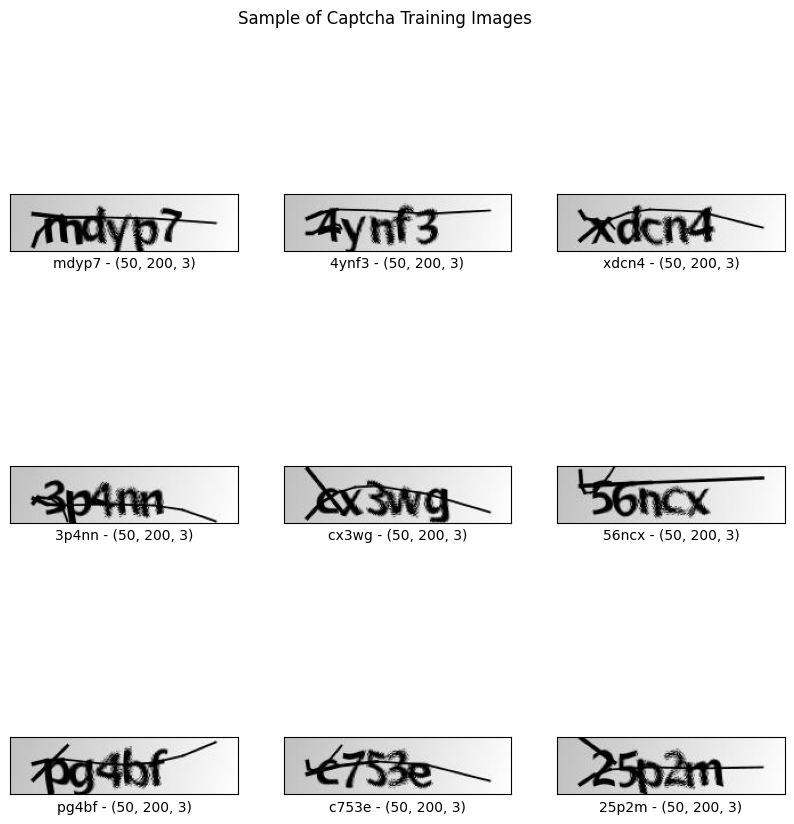

In [7]:
# Show a sample of training images and labels
plt.figure(figsize=(10, 10))

num_samples = 9
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(X_train)), size=num_samples, replace=False)

sample_images = X_train[indices]
sample_labels = y_train[indices]

for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"{decode_label(sample_labels[i])} - {sample_images[i].shape}")
plt.suptitle('Sample of Captcha Training Images')
plt.show()

# Model design

- Input Layer

In [8]:
input_layer = ks.layers.Input(X_train.shape[1:], name="input_layer")

- Middle layers

In [9]:
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', name="Conv_1")(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu', name="Conv_2")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu', name="Conv_3")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-11 23:52:42.383636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 23:52:42.383758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


- Output layer

In [10]:
out = [Dense(len(characters), name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
model = ks.Model(inputs=input_layer, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 50, 200, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv_1 (Conv2D)                (None, 50, 200, 32)  2432        ['input_layer[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 32)  0           ['Conv_1[0][0]']                 
                                                                                                  
 Conv_2 (Conv2D)                (None, 25, 100, 48)  38448       ['max_pooling2d[0][0]']      

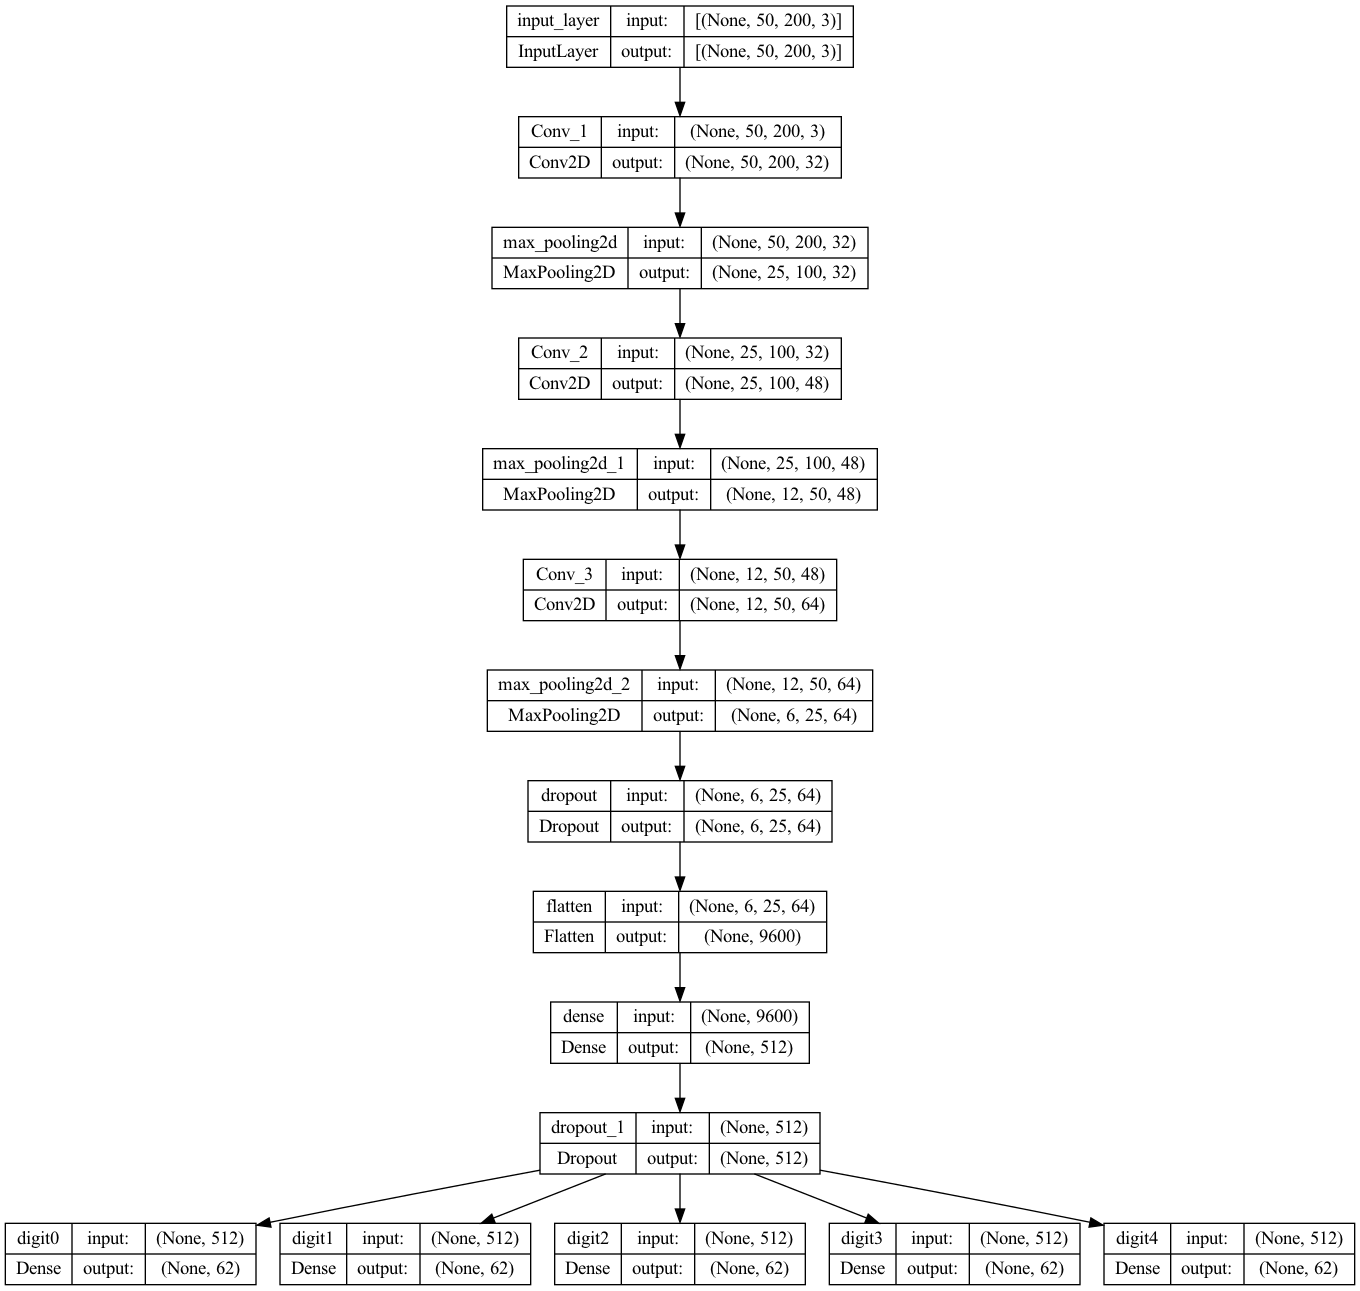

In [11]:
ks.utils.plot_model(model, show_shapes=True, show_layer_names=True)

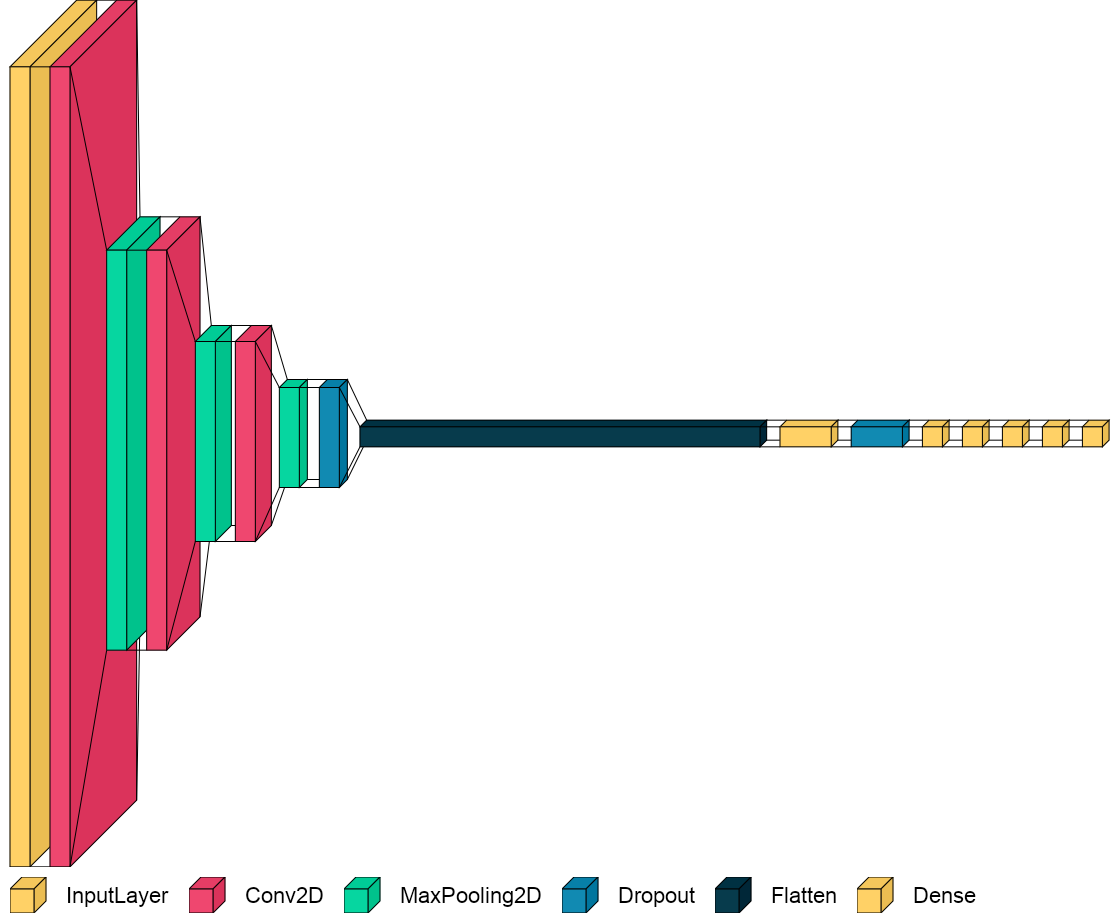

In [12]:
font = ImageFont.truetype("fonts/arial.ttf", 22)
visualkeras.layered_view(model, legend=True, font=font, spacing=20)

# Train and fit model

In [13]:
Y_train = []
Y_test = []

for i in range(NUM_OF_LETTERS):
    Y_train.append(y_train[:, i, :])
    Y_test.append(y_test[:, i, :])

# Define early stopping callback
earlystop_callback_0 = EarlyStopping(monitor='val_digit0_accuracy', patience=10, verbose=1)
earlystop_callback_1 = EarlyStopping(monitor='val_digit1_accuracy', patience=10, verbose=1)
earlystop_callback_2 = EarlyStopping(monitor='val_digit2_accuracy', patience=10, verbose=1)
earlystop_callback_3 = EarlyStopping(monitor='val_digit3_accuracy', patience=10, verbose=1)
earlystop_callback_4 = EarlyStopping(monitor='val_digit4_accuracy', patience=10, verbose=1)


history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    validation_split=0.15,
                    callbacks=[earlystop_callback_0, earlystop_callback_1, earlystop_callback_2, earlystop_callback_3, earlystop_callback_4])

Epoch 1/50


2023-04-11 23:52:43.776863: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-11 23:52:44.442809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 16.8423 - digit0_loss: 3.3799 - digit1_loss: 3.4003 - digit2_loss: 3.3338 - digit3_loss: 3.3747 - digit4_loss: 3.3534 - digit0_accuracy: 0.0583 - digit1_accuracy: 0.0557 - digit2_accuracy: 0.0738 - digit3_accuracy: 0.0751 - digit4_accuracy: 0.0829

2023-04-11 23:52:50.234798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 7s 115ms/step - loss: 16.8423 - digit0_loss: 3.3799 - digit1_loss: 3.4003 - digit2_loss: 3.3338 - digit3_loss: 3.3747 - digit4_loss: 3.3534 - digit0_accuracy: 0.0583 - digit1_accuracy: 0.0557 - digit2_accuracy: 0.0738 - digit3_accuracy: 0.0751 - digit4_accuracy: 0.0829 - val_loss: 15.0457 - val_digit0_loss: 2.9608 - val_digit1_loss: 2.9981 - val_digit2_loss: 3.0833 - val_digit3_loss: 3.0299 - val_digit4_loss: 2.9737 - val_digit0_accuracy: 0.1241 - val_digit1_accuracy: 0.0730 - val_digit2_accuracy: 0.0365 - val_digit3_accuracy: 0.0657 - val_digit4_accuracy: 0.0949
Epoch 2/50
25/25 [==============================] - 2s 70ms/step - loss: 15.0792 - digit0_loss: 3.0339 - digit1_loss: 3.0070 - digit2_loss: 3.0021 - digit3_loss: 3.0323 - digit4_loss: 3.0039 - digit0_accuracy: 0.0738 - digit1_accuracy: 0.0751 - digit2_accuracy: 0.0881 - digit3_accuracy: 0.0738 - digit4_accuracy: 0.1088 - val_loss: 14.7782 - val_digit0_loss: 2.8899 - val_digit1_loss: 2.9

# Evaluate

In [14]:
def decode_prediction(pred):
    # Convert pred to a numpy array
    pred = np.array(pred)
    label = ""
    for i in range(len(pred)):
        label += characters[np.argmax(pred[i][0])]
    return label


2023-04-11 23:53:25.456455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


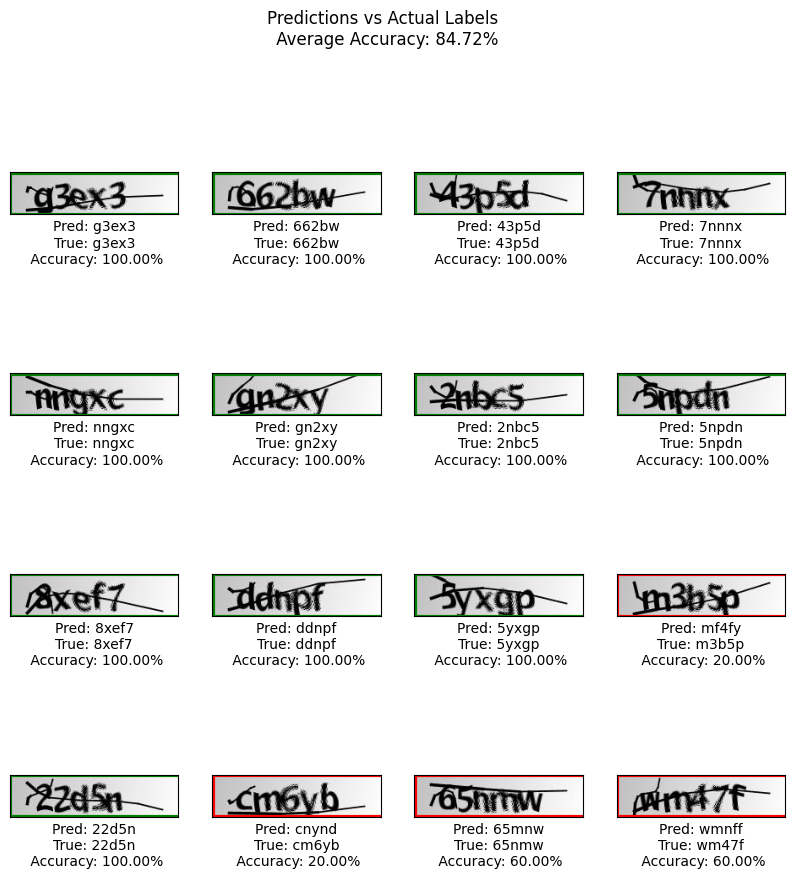

In [15]:
average_accuracy = []
for i in range(len(X_test)):
    pred = decode_prediction(model.predict(X_test[i:i+1]))
    true = decode_label(y_test[i])
    
    percent_correct = np.sum([pred[i] == true[i] for i in range(len(pred))]) / len(pred)
    
    average_accuracy.append(percent_correct)

average_accuracy = np.mean(average_accuracy)

# Compare the predictions with the actual labels
plt.figure(figsize=(10, 10))

num_samples = 16
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(X_test)), size=num_samples, replace=False)

sample_images = X_test[indices]
sample_labels = y_test[indices]



for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)
    pred = model.predict(sample_images[i:i+1])


    pred_label = decode_prediction(pred)
    true_label = decode_label(sample_labels[i])
    percent_correct = np.sum([pred_label[i] == true_label[i] for i in range(len(pred_label))]) / len(pred_label)
    plt.xlabel(f"Pred: {pred_label}\nTrue: {true_label}\n Accuracy: {percent_correct*100:.2f}%")

    

     # Draw a green border around the image if the prediction is correct and a red border if it is incorrect
    if pred_label == true_label:
        plt.gca().add_patch(plt.Rectangle((0, 0), 250, 50, fill=False, edgecolor='green', linewidth=3))
    else:
        plt.gca().add_patch(plt.Rectangle((0, 0), 240, 50, fill=False, edgecolor='red', linewidth=3))

plt.suptitle(f'Predictions vs Actual Labels \n Average Accuracy: {average_accuracy*100:.2f}%')
plt.show()


In [16]:
history.history.keys()

dict_keys(['loss', 'digit0_loss', 'digit1_loss', 'digit2_loss', 'digit3_loss', 'digit4_loss', 'digit0_accuracy', 'digit1_accuracy', 'digit2_accuracy', 'digit3_accuracy', 'digit4_accuracy', 'val_loss', 'val_digit0_loss', 'val_digit1_loss', 'val_digit2_loss', 'val_digit3_loss', 'val_digit4_loss', 'val_digit0_accuracy', 'val_digit1_accuracy', 'val_digit2_accuracy', 'val_digit3_accuracy', 'val_digit4_accuracy'])

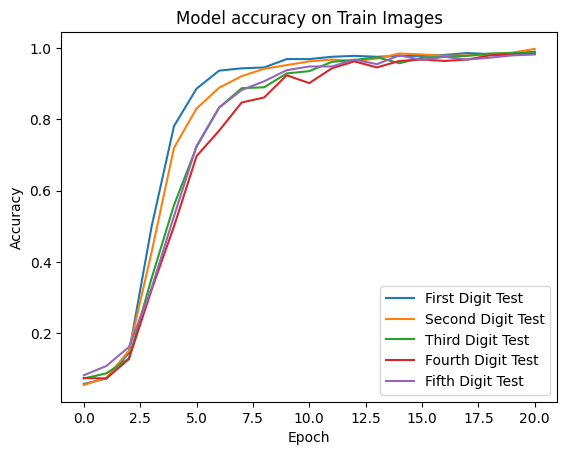

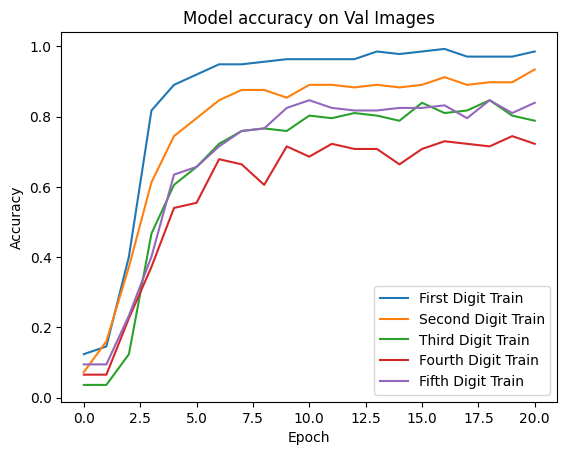

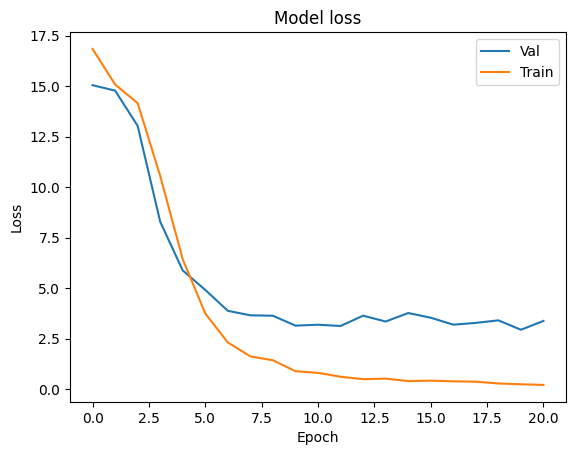

In [17]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = [] 
digit_acc_now = [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)]
val_digit_acc_now = [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)]
loss_now = history.history['loss']
val_loss_now = history.history['val_loss']
for i in range(NUM_OF_LETTERS):
    digit_acc[i].extend(digit_acc_now[i])
    val_digit_acc[i].extend(val_digit_acc_now[i])
loss.extend(loss_now)
val_loss.extend(val_loss_now)


# Plot training & validation accuracy values
for i in range(NUM_OF_LETTERS):
    s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
    plt.plot(digit_acc[i], label='%s Digit Test' % s)
plt.title('Model accuracy on Train Images')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

for i in range(NUM_OF_LETTERS):
    s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
    plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
plt.title('Model accuracy on Val Images')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



# Plot training & validation loss values
plt.plot(val_loss, label='Val')
plt.plot(loss, label='Train')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
